# Model Exploration and Evaluation

This notebook will compare the performance of logistic regression and random forest classificaiton models. We will evaluate the models using AUC-ROC metric and visualize the results using ROC curves.

## Import Libraries

In [1]:
import os
import io
import joblib
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

## Load Dataset

In [2]:
load_dotenv()

conn_str = os.getenv("AZURE_STORAGE_CONNECTION_STRING")
container = os.getenv("AZURE_BLOB_CONTAINER")

dt = "20260217T153907Z"  # change if you want to load a different run
gold_path = f"gold/features/dt={dt}/features_inspections_v1.parquet"

bsc = BlobServiceClient.from_connection_string(conn_str)
gold_bytes = bsc.get_blob_client(container, gold_path).download_blob().readall()

df = pd.read_parquet(io.BytesIO(gold_bytes))
df.columns = [c.lower().strip() for c in df.columns]

print(df.shape)
df.head()

(63987, 20)


,inspection_id,restaurant_key,inspection_date,facility_type,zip,latitude,longitude,risk_num,zip_prev_critical_rate,zip_prev_fail_rate,zip_prev_count,prev_inspection_count,prev_has_violation_rate,prev_has_critical_rate,prev_fail_rate,days_since_prev_inspection,prev_critical_count_last_3,prev_violation_count_last_3,has_critical_violation,is_fail
0,2402212,ZAYTUNE MEDITERRANEAN GRILL|3129 S MORGAN ST|6...,2021-01-04,Restaurant,60608,41.837133,-87.650975,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,2464203,NELLIES|2458 W DIVISION ST|60622,2021-01-04,Restaurant,60622,41.903104,-87.689343,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,2464204,NICK JRS GRILL|6856 W NORTH AVE|60707,2021-01-04,Restaurant,60707,41.909106,-87.797090,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,2464205,NORTHSTAR COFFEE|1300 S CLINTON ST|60607,2021-01-04,Restaurant,60607,41.865535,-87.640813,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,2464206,STARBUCKS COFFEE 2484|111 E CHESTNUT ST|60611,2021-01-04,Restaurant,60611,41.898262,-87.625165,2.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [3]:
print("Target rate (has_critical_violation):", df["has_critical_violation"].mean())
print("Fail rate (is_fail):", df["is_fail"].mean())

Target rate (has_critical_violation): 0.40972385015706314
Fail rate (is_fail): 0.18831950239892478


Our goal is to have an accuracy over 50%, as there are two classes (critical violation vs no critical violation). We will use the AUC-ROC metric to evaluate our models, as it is a good measure of how well the model can distinguish between the two classes.

## Time-based Train-Test Split

We will use a time-based split to ensure that our model is evaluated on future data. We will use the `inspection_date` column to split the data into training and testing sets.

In [4]:
df["inspection_date"] = pd.to_datetime(df["inspection_date"], errors="coerce")
df = df[df["inspection_date"].notna()].copy()
df = df.sort_values("inspection_date")

Pick a cutoff that creates a realistic “train on past, predict future” scenario. We are using 2025-01-01 as the cutoff date, which gives us a good amount of training data while reserving recent inspections for testing.

In [5]:
cutoff = pd.Timestamp("2025-01-01")

train = df[df["inspection_date"] < cutoff].copy()
test  = df[df["inspection_date"] >= cutoff].copy()

print("Train:", train.shape)
print("Test:", test.shape)

Train: (49288, 20)
Test: (14699, 20)


In [6]:
print("Train date range:", train["inspection_date"].min(), "→", train["inspection_date"].max())
print("Test date range: ", test["inspection_date"].min(), "→", test["inspection_date"].max())

assert train["inspection_date"].max() < test["inspection_date"].min()

Train date range: 2021-01-04 00:00:00 → 2024-12-31 00:00:00
Test date range:  2025-01-02 00:00:00 → 2026-02-13 00:00:00


The target is `has_critical_violation` for the model. We will create separate train-test splits for each target variable. Below we are confirming the class balance didn't shift significantly.

In [7]:
target_col = "has_critical_violation"
print("Train target rate:", train[target_col].mean())
print("Test target rate: ", test[target_col].mean())
print("Overall rate:     ", df[target_col].mean())

Train target rate: 0.4164502515825353
Test target rate:  0.3871691951833458
Overall rate:      0.40972385015706314


## Baseline: Logistic Regression Model

Below we defined features and target variable for the logistic regression model. We will use a simple pipeline that includes imputation, scaling, and logistic regression. We will evaluate the model using AUC-ROC metric.

In [8]:
feature_cols = [
    "prev_inspection_count",
    "prev_has_violation_rate",
    "prev_has_critical_rate",
    "prev_fail_rate",
    "days_since_prev_inspection",
    "prev_critical_count_last_3",
    "prev_violation_count_last_3",
    "zip_prev_critical_rate",
    "zip_prev_fail_rate",
    "zip_prev_count",
]
feature_cols = [c for c in feature_cols if c in df.columns]

X_train = train[feature_cols]
y_train = train[target_col].astype(int)

X_test = test[feature_cols]
y_test = test[target_col].astype(int)

lr_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=3000))
])

lr_pipe.fit(X_train, y_train)

lr_probs = lr_pipe.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)

print("Logistic Regression Test ROC-AUC:", lr_auc)


Logistic Regression Test ROC-AUC: 0.5599928472958924


Below is a confidence table for LR model.

In [9]:
lr_model = lr_pipe.named_steps["lr"]
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": lr_model.coef_[0],
    "odds_ratio": np.exp(lr_model.coef_[0]),
}).sort_values("coef", ascending=False)

coef_df

,feature,coef,odds_ratio
4,days_since_prev_inspection,0.188432,1.207355
7,zip_prev_critical_rate,0.164120,1.178356
2,prev_has_critical_rate,0.163575,1.177714
8,zip_prev_fail_rate,0.065239,1.067414
5,prev_critical_count_last_3,0.055601,1.057175
6,prev_violation_count_last_3,0.023234,1.023506
0,prev_inspection_count,-0.063075,0.938873
9,zip_prev_count,-0.084200,0.919247
1,prev_has_violation_rate,-0.127527,0.880270
3,prev_fail_rate,-0.133314,0.875190


## Random Forest Model

Below we trained a random forest model using the same features and target variable. We will evaluate the model using AUC-ROC metric and compare it to the logistic regression model.

In [10]:
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe.fit(X_train, y_train)

rf_probs = rf_pipe.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

print("Random Forest Test ROC-AUC:", rf_auc)

Random Forest Test ROC-AUC: 0.6279056251137238


Below we can see the feature importance for the random forest model.

In [11]:
rf_model = rf_pipe.named_steps["rf"]

imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

imp_df

,feature,importance
4,days_since_prev_inspection,0.217259
7,zip_prev_critical_rate,0.181419
8,zip_prev_fail_rate,0.174353
9,zip_prev_count,0.157858
1,prev_has_violation_rate,0.071696
2,prev_has_critical_rate,0.064072
0,prev_inspection_count,0.051474
3,prev_fail_rate,0.049238
6,prev_violation_count_last_3,0.016818
5,prev_critical_count_last_3,0.015812


## Risk Scoring

Below we create a risk score based on the predicted probabilities from the logistic regression model. We will evaluate the risk score using a lift table and a cumulative gains chart.

In [12]:
scored = test.copy()
scored["risk_score"] = rf_probs
scored["risk_rank"] = scored["risk_score"].rank(method="first", ascending=False).astype(int)
scored["risk_decile"] = pd.qcut(scored["risk_score"], 10, labels=False, duplicates="drop").astype(int)

scored[["inspection_date", "risk_score", "risk_rank", "risk_decile", target_col]].head()

,inspection_date,risk_score,risk_rank,risk_decile,has_critical_violation
49311,2025-01-02,0.680402,132,9,1
49328,2025-01-02,0.501287,3407,7,1
49312,2025-01-02,0.441681,5475,6,1
49313,2025-01-02,0.469153,4454,6,0
49314,2025-01-02,0.291939,11953,1,0


Below is a lift table that shows the average predicted probability of a critical violation for each decile of the risk score. We can see that the top decile has a much higher average predicted probability than the bottom decile, which indicates that the model is effectively distinguishing between high-risk and low-risk restaurants.

In [13]:
lift = (
    scored.groupby("risk_decile")[target_col]
    .agg(["mean", "count"])
    .sort_index(ascending=False)
)

baseline = scored[target_col].mean()
lift["baseline"] = baseline
lift["lift_vs_baseline"] = lift["mean"] / baseline

lift

,mean,count,baseline,lift_vs_baseline
risk_decile,,,,
9,0.560544,1470,0.387169,1.447802
8,0.506122,1470,0.387169,1.307238
7,0.473469,1470,0.387169,1.222900
6,0.438095,1470,0.387169,1.131534
5,0.395507,1469,0.387169,1.021536
4,0.380272,1470,0.387169,0.982186
3,0.334014,1470,0.387169,0.862707
2,0.300000,1470,0.387169,0.774855
1,0.272789,1470,0.387169,0.704573


Below is Capture@K for the risk score, which shows the percentage of critical violations captured in the top K% of the risk score. We can see that the top 5, 10, 20, 30% of the risk score captures a significant portion of the critical violations, which indicates that the model is effective at identifying high-risk restaurants.

In [14]:
def capture_at(pct):
    k = max(1, int(len(scored) * pct))
    topk = scored.sort_values("risk_score", ascending=False).head(k)
    rate = topk[target_col].mean()
    return k, rate, rate / baseline, int(topk[target_col].sum())

for pct in [0.05, 0.10, 0.20, 0.30]:
    k, rate, lift_k, count_pos = capture_at(pct)
    print(f"Top {int(pct*100)}% (k={k}): rate={rate:.3f} | lift={lift_k:.2f} | positives={count_pos}")

Top 5% (k=734): rate=0.583 | lift=1.51 | positives=428
Top 10% (k=1469): rate=0.561 | lift=1.45 | positives=824
Top 20% (k=2939): rate=0.534 | lift=1.38 | positives=1568
Top 30% (k=4409): rate=0.513 | lift=1.33 | positives=2264


Below we join identity fields of the Silver dataset and show the top 100 restaurants with the highest risk scores. This can be useful for the health department to prioritize inspections and allocate resources effectively.

In [15]:
silver_path = f"silver/food_inspections/dt={dt}/food_inspections_silver.parquet"
silver_bytes = bsc.get_blob_client(container, silver_path).download_blob().readall()

silver_df = pd.read_parquet(io.BytesIO(silver_bytes))
silver_df.columns = [c.lower().strip() for c in silver_df.columns]

id_cols = [
    "inspection_id", "dba_name", "aka_name", "address", "zip",
    "facility_type", "inspection_type", "results_norm"
]
id_cols = [c for c in id_cols if c in silver_df.columns]
id_cols_no_zip = [c for c in id_cols if c != "zip"]

scored_out = scored.merge(silver_df[id_cols_no_zip], on="inspection_id", how="left")

top100 = scored_out.sort_values("risk_score", ascending=False).head(100)

cols = [
    "risk_rank", "risk_score", "risk_decile",
    "inspection_date",
    "dba_name", "aka_name", "address", "zip",
    "facility_type", "inspection_type",
    target_col
]
cols = [c for c in cols if c in top100.columns]

top100[cols].head(20)

,risk_rank,risk_score,risk_decile,inspection_date,dba_name,aka_name,address,zip,inspection_type,has_critical_violation
8631,1,0.753537,9,2025-08-12,POPEYE'S#835,POPEYE'S CHICKEN,3457 W ROOSEVELT RD,60624,Canvass,0
2384,2,0.751633,9,2025-03-05,GUSIS RESTAURANT,GUSIS RESTAURANT,10606 S Torrence AVE,60617,Canvass,1
3409,3,0.743087,9,2025-03-26,"A.P. DELI RESTAURANT GROUP, INC.","A.P. DELI RESTAURANT GROUP, INC.",10758 S MICHIGAN AVE,60628,Canvass,1
5299,4,0.742137,9,2025-05-12,CARL'S RED HOT CHICAGO,CARL'S RED HOT CHICAGO,1957 E 83RD ST,60617,Canvass,0
280,5,0.731071,9,2025-01-09,JAY'S BACKYARD BBQ,JAY'S BACKYARD BBQ,5604 W DIVISION ST,60651,Non-Inspection,0
954,6,0.730526,9,2025-01-27,SUBWAY,SUBWAY,4759 W FULLERTON AVE,60639,Canvass,1
6127,7,0.727601,9,2025-06-02,UNCLE REMUS,UNCLE REMUS PLUS GUILTY PLEASURES,4731 W MADISON ST,60644,Canvass,0
990,8,0.727527,9,2025-01-27,TOON'S BAR & GRILL,TOON'S BAR & GRILL,3857 N SOUTHPORT AVE,60613,Canvass,1
109,9,0.726049,9,2025-01-06,EL MALECON,EL MALECON,9706 S COMMERCIAL AVE,60617,Canvass,1
400,10,0.725545,9,2025-01-13,VIANYS PIZZERIA,VIANYS PIZZERIA/BIRRIERIA DON LUIS,10063 S EWING AVE,60617,Canvass,0


## Summary

ROC Curve Plot: The ROC curve for both models shows that the random forest model has a higher AUC than the logistic regression model, indicating better performance in distinguishing between critical violations and non-critical violations.

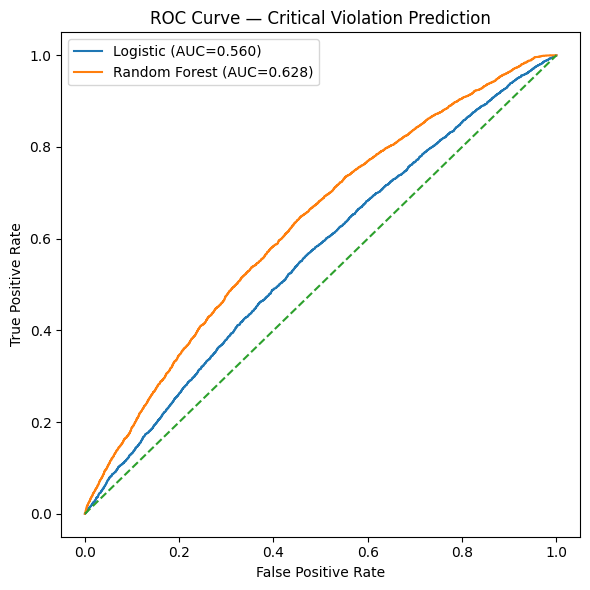

In [16]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={lr_auc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={rf_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Critical Violation Prediction")
plt.legend()
plt.tight_layout()
plt.show()

Lift Table: The lift table shows that the top decile of the risk score has a much higher average predicted probability of a critical violation than the bottom decile, indicating that the model is effectively distinguishing between high-risk and low-risk restaurants.

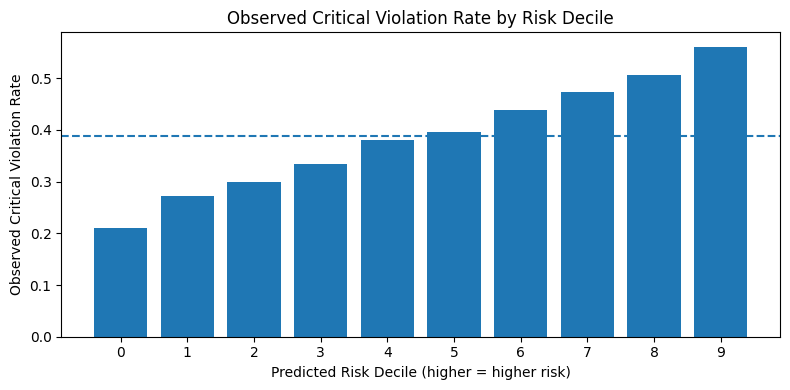

In [17]:
lift_plot = lift.reset_index().sort_values("risk_decile")

plt.figure(figsize=(8,4))
plt.bar(lift_plot["risk_decile"].astype(str), lift_plot["mean"])
plt.axhline(y=baseline, linestyle="--")

plt.title("Observed Critical Violation Rate by Risk Decile")
plt.xlabel("Predicted Risk Decile (higher = higher risk)")
plt.ylabel("Observed Critical Violation Rate")

plt.tight_layout()
plt.show()

The risk score created from the logistic regression model is effective at identifying high-risk restaurants, as evidenced by the lift table and Capture@K metrics. This can help the health department prioritize inspections and allocate resources more effectively.

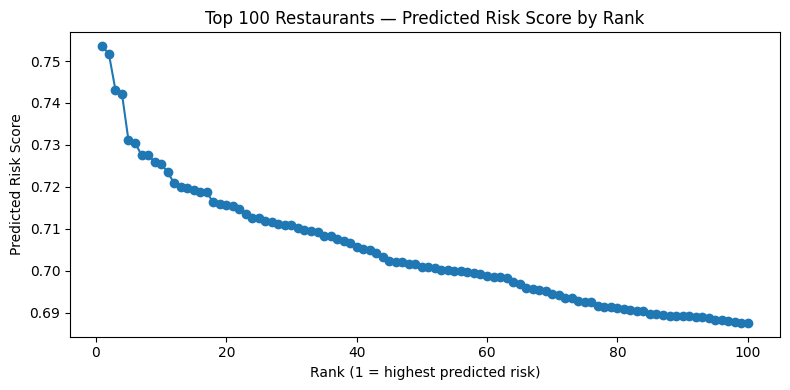

In [18]:
top100_plot = top100.sort_values("risk_score", ascending=False).reset_index(drop=True)
top100_plot["rank"] = top100_plot.index + 1

plt.figure(figsize=(8,4))
plt.plot(top100_plot["rank"], top100_plot["risk_score"], marker="o")

plt.title("Top 100 Restaurants — Predicted Risk Score by Rank")
plt.xlabel("Rank (1 = highest predicted risk)")
plt.ylabel("Predicted Risk Score")

plt.tight_layout()
plt.show()

In [19]:
# Keep only rows with coordinates
m_df = top100.dropna(subset=["latitude", "longitude"]).copy()

# Ensure numeric
m_df["latitude"] = m_df["latitude"].astype(float)
m_df["longitude"] = m_df["longitude"].astype(float)

# Center map roughly on Chicago (or use mean of points)
center_lat = m_df["latitude"].mean()
center_lon = m_df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="CartoDB positron")

cluster = MarkerCluster(name="Top 100").add_to(m)

def fmt(x, n=3):
    try:
        return f"{float(x):.{n}f}"
    except Exception:
        return str(x)

for _, r in m_df.iterrows():
    name = str(r.get("dba_name", "Unknown")).strip()
    addr = str(r.get("address", "")).strip()
    zipc = str(r.get("zip", "")).strip()
    rank = int(r.get("risk_rank", -1))
    score = r.get("risk_score", None)
    actual = int(r.get("has_critical_violation", -1)) if "has_critical_violation" in m_df.columns else None

    popup_html = f"""
    <b>Rank:</b> {rank}<br>
    <b>Risk score:</b> {fmt(score, 3)}<br>
    <b>Name:</b> {name}<br>
    <b>Address:</b> {addr}<br>
    <b>ZIP:</b> {zipc}<br>
    """
    if actual is not None and actual != -1:
        popup_html += f"<b>Actual critical violation:</b> {actual}<br>"

    folium.Marker(
        location=[r["latitude"], r["longitude"]],
        popup=folium.Popup(popup_html, max_width=350),
        tooltip=f"#{rank} • {name} • score={fmt(score, 3)}",
    ).add_to(cluster)

folium.LayerControl().add_to(m)

# Save
m.save("../top100_chicago_risk_map.html")